In [5]:
# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Corrected imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture  # Updated GMM import
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

# SK-learn libraries for feature preprocessing.
from sklearn import preprocessing

# SK-learn libraries for dimensionality reduction.
from sklearn.decomposition import PCA


In [10]:
import numpy as np

ff = "train.csv"
with open(ff) as f:
    column_names = f.readline()
    data = np.loadtxt(f, delimiter=",", skiprows=1)

y, X = data[:, -1].astype('int'), data[:, :-1]

ff_test = "train.csv"
with open(ff_test) as f_test:
    column_names_test = f_test.readline()
    data_test = np.loadtxt(f_test, delimiter=",", skiprows=1)

X_test = data_test  # No labels in the test set

print('The test dataset contains {0} observations with {1} features each.'.format(X_test.shape[0], X_test.shape[1]))
print('\t(The 1st one is not really a feature but an observation ID.)')
print('The training dataset contains {0} observations with the same {1} features each.'.format(X.shape[0], X.shape[1]))
print('For this training set, we know the corresponding category (forest cover type) of the {0} observations.'.format(y.shape[0]))


The test dataset contains 15119 observations with 56 features each.
	(The 1st one is not really a feature but an observation ID.)
The training dataset contains 15119 observations with the same 55 features each.
For this training set, we know the corresponding category (forest cover type) of the 15119 observations.


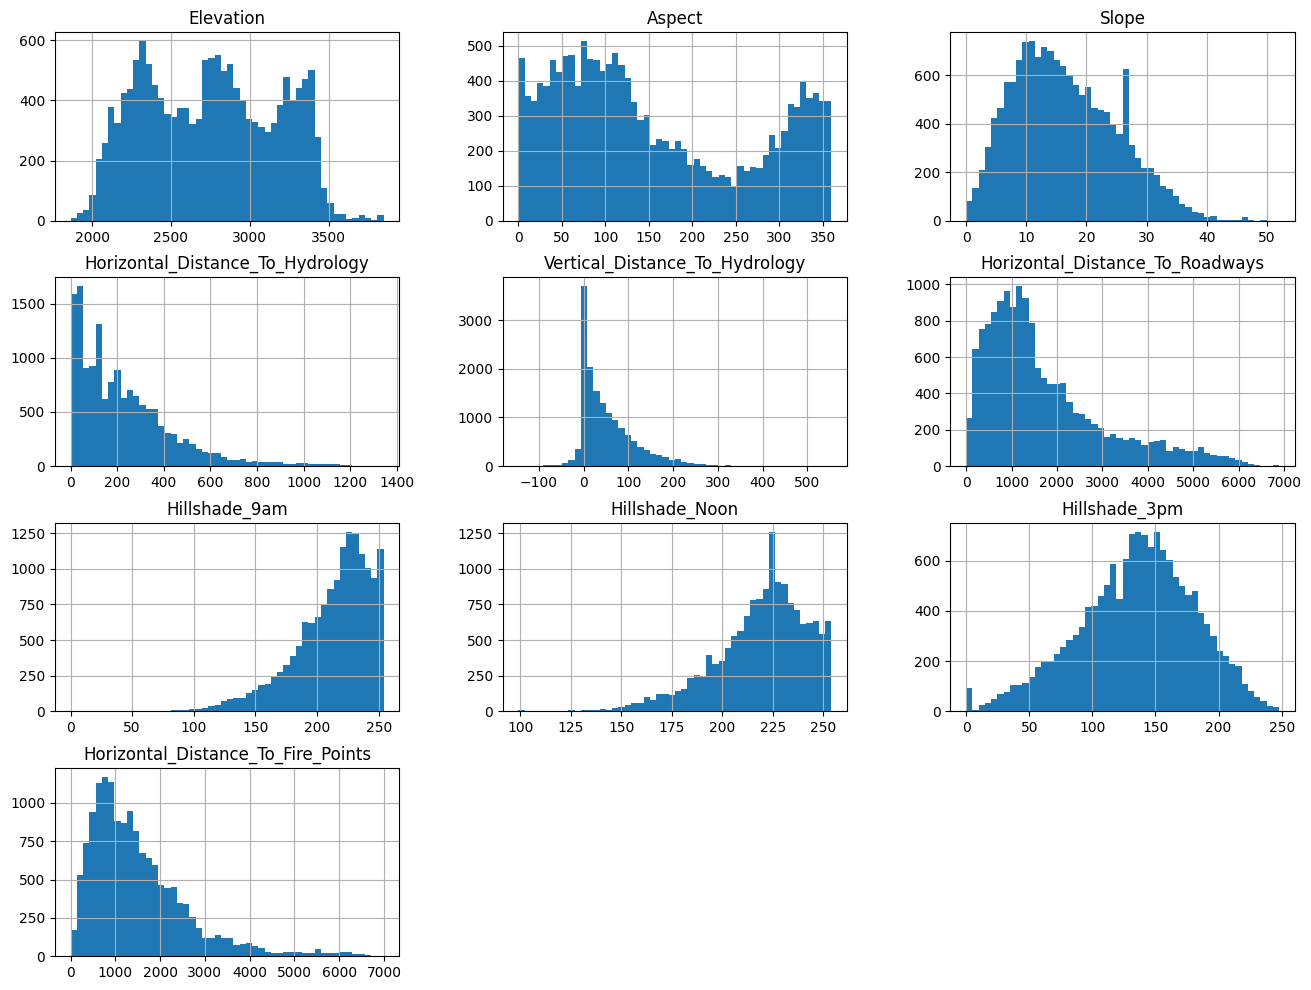

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

Train_panda = pd.read_csv("train.csv")
Train_panda.iloc[:, 1:11].hist(figsize=(16, 12), bins=50)
plt.show()


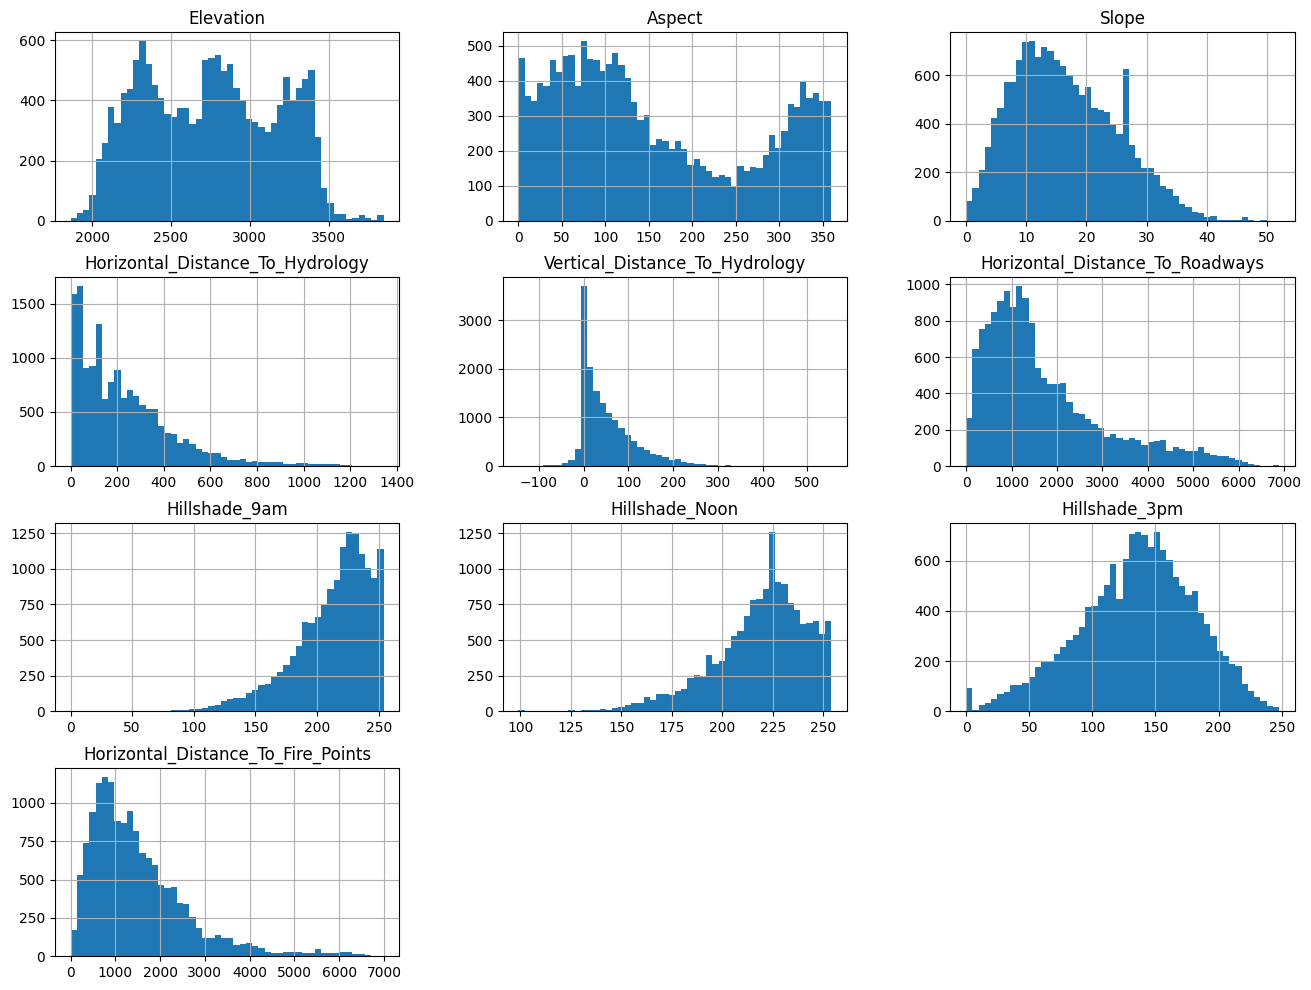

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

Test_panda = pd.read_csv('train.csv')
Test_panda.iloc[:, 1:11].hist(figsize=(16, 12), bins=50)
plt.show()


In [16]:
import numpy as np

np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# Split into train (90%) and dev (10%)
train_size = int(X.shape[0] * 0.9)

# Also discard 1st feature (ID number that doesn't provide info about the label)
y_train, X_train = y[:train_size], X[:train_size, 1:]
y_dev, X_dev = y[train_size:], X[train_size:, 1:]
X_test = X_test[:, 1:]

print(X_dev.shape, X_train.shape)


(1512, 54) (13607, 54)


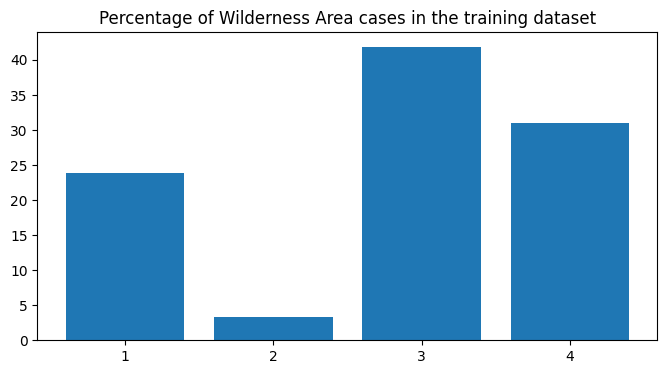

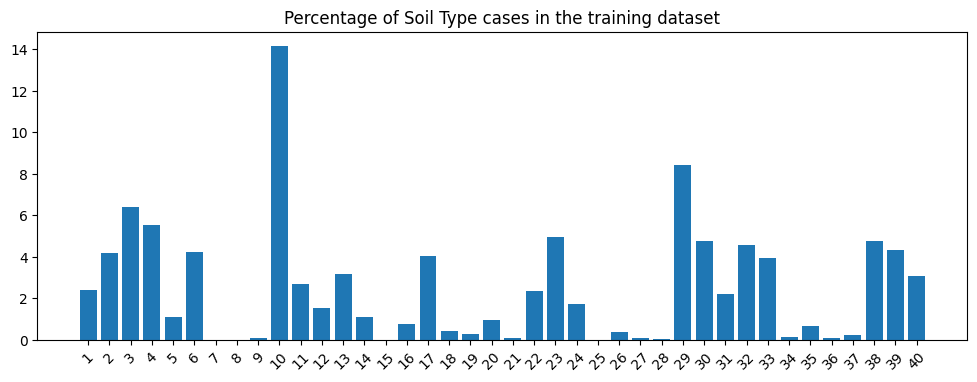

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Check if X_train has the required columns
if X_train.shape[1] < 54:
    raise ValueError(f"X_train should have at least 54 features, but it has {X_train.shape[1]}")

# Convert to float for division safety
prop_wilderness = 100 * X_train[:, 10:14].sum(axis=0).astype(float) / X_train[:, 10:14].sum()
prop_soil = 100 * X_train[:, 14:54].sum(axis=0).astype(float) / X_train[:, 14:54].sum()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), prop_wilderness, align="center")
plt.title("Percentage of Wilderness Area cases in the training dataset")
plt.xticks(np.arange(4), [str(i) for i in np.arange(1, 5)])

plt.figure(figsize=(12, 4))
plt.bar(np.arange(40), prop_soil, align="center")
plt.title("Percentage of Soil Type cases in the training dataset")
plt.xticks(np.arange(40), [str(i) for i in np.arange(1, 41)], rotation=45)

plt.show()


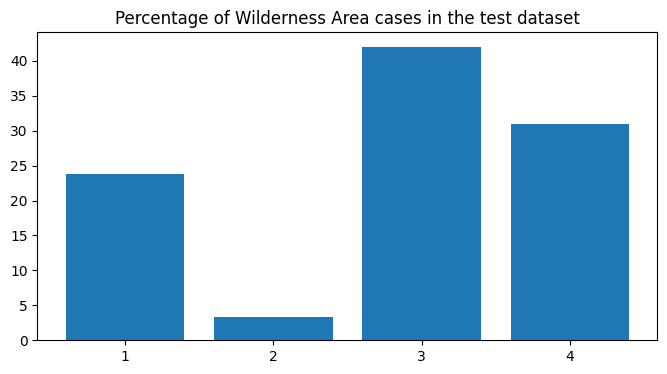

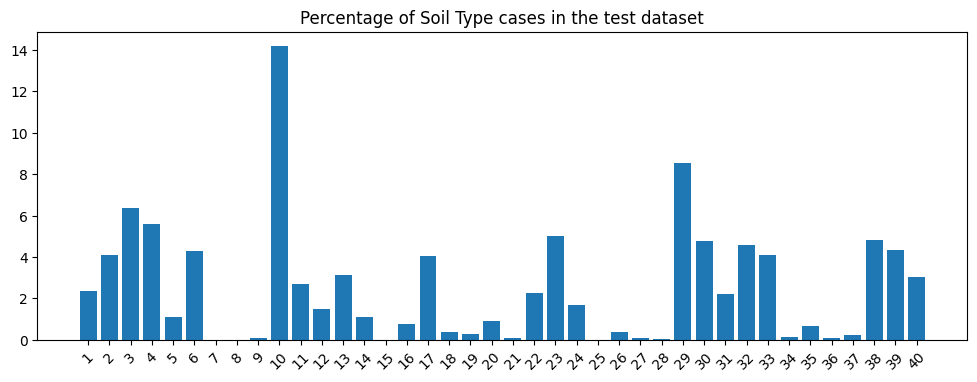

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure X_test has enough features
if X_test.shape[1] < 54:
    raise ValueError(f"X_test should have at least 54 features, but it has {X_test.shape[1]}")

# Avoid division by zero errors
wilderness_sum = X_test[:, 10:14].sum()
soil_sum = X_test[:, 14:54].sum()

prop_wilderness = 100 * X_test[:, 10:14].sum(axis=0) / (wilderness_sum + 1e-8)
prop_soil = 100 * X_test[:, 14:54].sum(axis=0) / (soil_sum + 1e-8)

# Plot Wilderness Area Distribution
plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), prop_wilderness, align="center")
plt.title("Percentage of Wilderness Area cases in the test dataset")
plt.xticks(np.arange(4), [str(i) for i in np.arange(1, 5)])

# Plot Soil Type Distribution
plt.figure(figsize=(12, 4))
plt.bar(np.arange(40), prop_soil, align="center")
plt.title("Percentage of Soil Type cases in the test dataset")
plt.xticks(np.arange(40), [str(i) for i in np.arange(1, 41)], rotation=45)

plt.show()


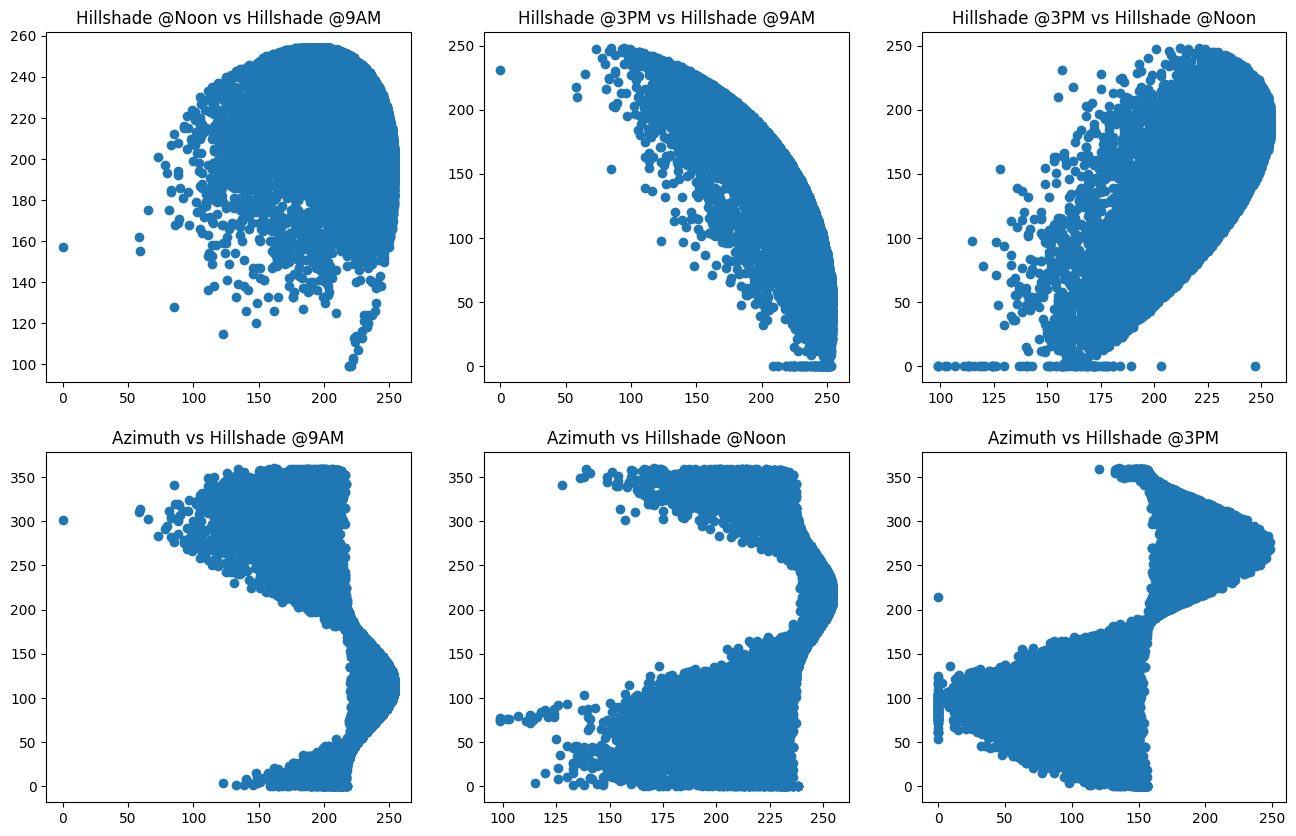

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances

# Compute Euclidean distance to hydrology
distance_to_hydrology = euclidean_distances(X_train[:, (3, 4)], np.array([[0, 0]]))

# Append distance feature correctly
X_train_new = np.hstack((X_train, distance_to_hydrology))

# Thresholding hillshade features
X_train_new[:, 6] = np.floor_divide(X_train[:, 6], 64)
X_train_new[:, 7] = np.floor_divide(X_train[:, 7], 64)
X_train_new[:, 8] = np.floor_divide(X_train[:, 8], 64)

# Remove the original distance columns (3 and 4)
X_train_new_del = np.delete(X_train_new, [3, 4], axis=1)

# Repeat for dev set
distance_to_hydrology_dev = euclidean_distances(X_dev[:, (3, 4)], np.array([[0, 0]]))
X_dev_new = np.hstack((X_dev, distance_to_hydrology_dev))

X_dev_new[:, 6] = np.floor_divide(X_dev[:, 6], 64)
X_dev_new[:, 7] = np.floor_divide(X_dev[:, 7], 64)
X_dev_new[:, 8] = np.floor_divide(X_dev[:, 8], 64)

X_dev_new_del = np.delete(X_dev_new, [3, 4], axis=1)

# Plot Hillshade relationships
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.scatter(X_train[:, 6], X_train[:, 7])
plt.title("Hillshade @Noon vs Hillshade @9AM")

plt.subplot(2, 3, 2)
plt.scatter(X_train[:, 6], X_train[:, 8])
plt.title("Hillshade @3PM vs Hillshade @9AM")

plt.subplot(2, 3, 3)
plt.scatter(X_train[:, 7], X_train[:, 8])
plt.title("Hillshade @3PM vs Hillshade @Noon")

plt.subplot(2, 3, 4)
plt.scatter(X_train[:, 6], X_train[:, 1])
plt.title("Azimuth vs Hillshade @9AM")

plt.subplot(2, 3, 5)
plt.scatter(X_train[:, 7], X_train[:, 1])
plt.title("Azimuth vs Hillshade @Noon")

plt.subplot(2, 3, 6)
plt.scatter(X_train[:, 8], X_train[:, 1])
plt.title("Azimuth vs Hillshade @3PM")

plt.show()


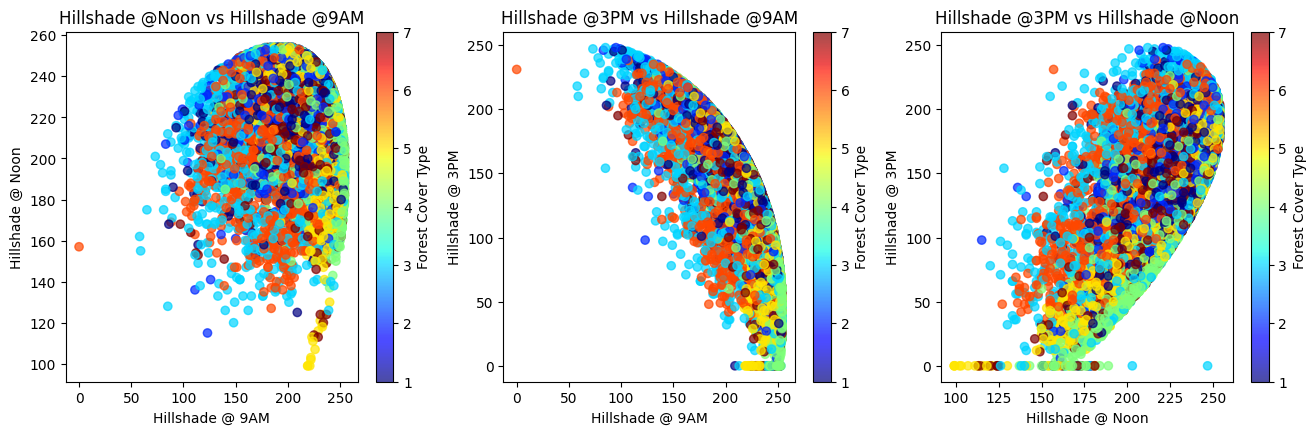

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Scatter Plot of hillshade index
plt.subplot(2, 3, 1)
sc1 = plt.scatter(X_train[:, 6], X_train[:, 7], c=y_train, cmap=plt.cm.jet, alpha=0.7)
plt.colorbar(sc1, label="Forest Cover Type")  # Add color legend
plt.xlabel("Hillshade @ 9AM")
plt.ylabel("Hillshade @ Noon")
plt.title("Hillshade @Noon vs Hillshade @9AM")

plt.subplot(2, 3, 2)
sc2 = plt.scatter(X_train[:, 6], X_train[:, 8], c=y_train, cmap=plt.cm.jet, alpha=0.7)
plt.colorbar(sc2, label="Forest Cover Type")
plt.xlabel("Hillshade @ 9AM")
plt.ylabel("Hillshade @ 3PM")
plt.title("Hillshade @3PM vs Hillshade @9AM")

plt.subplot(2, 3, 3)
sc3 = plt.scatter(X_train[:, 7], X_train[:, 8], c=y_train, cmap=plt.cm.jet, alpha=0.7)
plt.colorbar(sc3, label="Forest Cover Type")
plt.xlabel("Hillshade @ Noon")
plt.ylabel("Hillshade @ 3PM")
plt.title("Hillshade @3PM vs Hillshade @Noon")

plt.show()


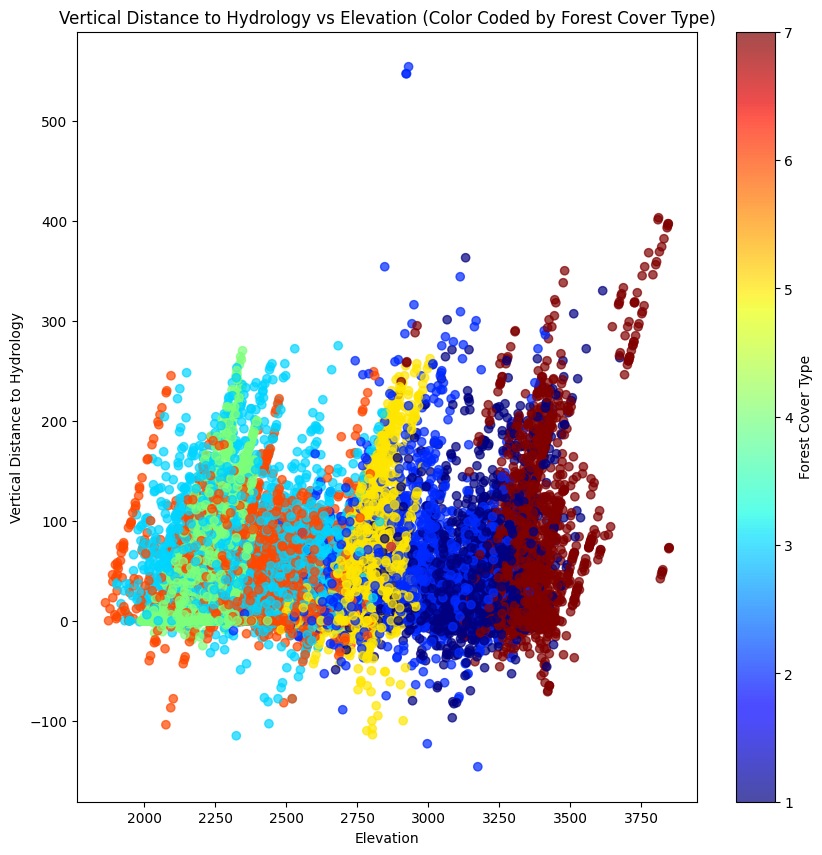

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Scatter plot
sc = plt.scatter(X_train[:, 0], X_train[:, 4], c=y_train, cmap=plt.cm.jet, alpha=0.7)

# Labels
plt.xlabel("Elevation")  # Replace with name_features[1] if correct
plt.ylabel("Vertical Distance to Hydrology")  # Replace with name_features[5] if correct

# Add color legend
plt.colorbar(sc, label="Forest Cover Type")

plt.title("Vertical Distance to Hydrology vs Elevation (Color Coded by Forest Cover Type)")
plt.show()


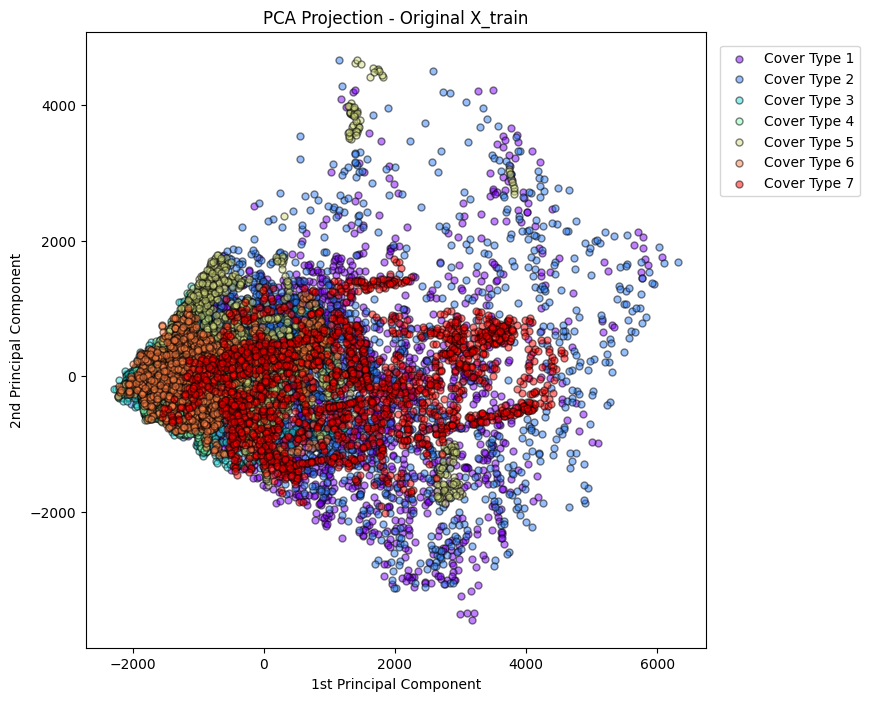

NameError: name 'X_train_std' is not defined

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot(dataset, title="PCA Projection of Forest Cover Types"):
    pc_2 = PCA(n_components=2)
    X_train_2pc = pc_2.fit_transform(dataset)

    # Define colors for each unique class in y_train
    unique_classes = np.unique(y_train)
    Colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))

    plt.figure(figsize=(8, 8))
    
    for i, label in enumerate(unique_classes):
        plt.scatter(
            X_train_2pc[y_train == label, 0],  # 1st PCA component
            X_train_2pc[y_train == label, 1],  # 2nd PCA component
            c=[Colors[i]], 
            alpha=0.5, 
            s=25, 
            edgecolor='black', 
            label=f'Cover Type {label}'
        )
    
    plt.xlabel("1st Principal Component")
    plt.ylabel("2nd Principal Component")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=1.)
    plt.show()

# Apply PCA on different datasets
plot(X_train, title="PCA Projection - Original X_train")
plot(X_train_std, title="PCA Projection - Standardized X_train")
plot(X_train_minmax, title="PCA Projection - Min-Max Scaled X_train")
